# Assignment 4b - Graph Convolutional Networks
## Deep Learning Course - Vrije Universiteit Amsterdam, 2022

#### Instructions on how to use this notebook:

This notebook is hosted on Google Colab. To be able to work on it, you have to create your own copy. Go to *File* and select *Save a copy in Drive*.

You can also avoid using Colab entirely, and download the notebook to run it on your own machine. If you choose this, go to *File* and select *Download .ipynb*.

The advantage of using Colab is that you can use a GPU. You can complete this assignment with a CPU, but it will take a bit longer. Furthermore, we encourage you to train using the GPU not only for faster training, but also to get experience with this setting. This includes moving models and tensors to the GPU and back. This experience is very valuable because for many interesting models and large datasets (like large CNNs for ImageNet, or Transformer models trained on Wikipedia), training on GPU is the only feasible way.

The default Colab runtime does not have a GPU. To change this, go to *Runtime - Change runtime type*, and select *GPU* as the hardware accelerator. The GPU that you get changes according to what resources are available at the time, and its memory can go from a 5GB, to around 18GB if you are lucky. If you are curious, you can run the following in a code cell to check:

```sh
!nvidia-smi
```

Note that despite the name, Google Colab does  not support collaborative work without issues. When two or more people edit the notebook concurrently, only one version will be saved. You can choose to do group programming with one person sharing the screen with the others, or make multiple copies of the notebook to work concurrently.

**Submission:** Upload your notebook in .ipynb format to Canvas. The code and answers to the questions in the notebook are sufficient, no separate report is expected.

In [ ]:
!nvidia-smi

Wed Dec 13 22:00:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Introduction

Graphs are very useful data structures that allow us to represent sets of entities and the way they are related among each other. In a graph, entities are also known as *nodes*, and any link between entities is also called an *edge*.

Examples of real world objects that can be modeled as graphs are social networks, where entities are people and relations denote friendship; and molecules, where entities are atoms and relations indicate a bond between them.

There has been increased interest in the recent years in the application of deep learning architectures to graph-structured data, for tasks like predicting missing relations between entities, classifying entities, and classifying graphs. This interest has been spurred by the introduction of Graph Convolutional Networks (GCNs).

In this assignment, you will implement and experiment with one of the first versions of the GCN, proposed by Thomas Kipf and Max Welling in their 2017 paper, [Semi-supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907). In particular, the goals of this assignment are to

- Understand how GCNs are formulated
- Implement the GCN using PyTorch
- Train and evaluate a model for semi-supervised node classification in citation networks
- Train and evaluate a model for binary classification of molecules

### Representing graphs

Suppose we have the following graph:

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/01-graph.png" width="200">

This is an undirected graph (since the edges have no specified direction) with 4 nodes. One way to represent the connectivity structure of the graph is by means of the **adjacency matrix**. The $i$-th row of the matrix contains a 1 in the $j$-th column, if nodes $i$ and $j$ are connected. For an undirected graph like the one above, this means that the adjacency matrix

- Is symmetric (e.g. an edge between 0 and 2 is equivalent as an edge between 2 and 0)
- Is square, of size $n\times n$ where $n$ is the number of nodes

The adjacency matrix for the graph above is then the following:

$$
A =
\begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 1 & 0 \\
1 & 1 & 0 & 1 \\
0 & 0 & 1 & 0
\end{bmatrix}
$$

A second matrix of interest is the **degree matrix**. This is a diagonal matrix where the $i$-th element of the diagonal indicates the number of edges connected to node $i$. Note that these can be obtained from $A$ by summing across the columns, or the rows. For our example, the degree matrix is

$$
D = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 3 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

For specific applications, each node in the graph will have an associated vector of features $x\in\mathbb{R}^c$. If our graph is a social network, then the vector of features can contain information like age, location, and musical tastes, in a specific numeric format. In the case of a molecule, the node could represent an atom and have features like the atomic mass, etc. We can lay out the features in a matrix $X\in\mathbb{R}^{n\times c}$, so that the feature vector for node $i$ is in the $i$-th row.

### Loading a citation network

To move to a real world example, we will start with the Cora dataset. This dataset represents a citation network, where nodes are scientific publications, edges denote citations between them, and features are a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) extracted from their contents.

This graph contains labels for nodes, that represent a specific topic. We will use these for a node classification task.

To easily load it, we will use [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html) (PyG), a deep learning library for graph-structured data.

In [1]:
# Install PyTorch Geometric
import torch
try:
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version.
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric
    import torch_geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 69.9 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.9 MB/s eta 0:00:00


We can now use the library to download and import the dataset. Initializing the `Planetoid` class returns a `Dataset` object that can contain multiple graphs. In this task we will only use the `Cora` dataset (the citation network) and hence, we will select only the first element.

In [2]:
from torch_geometric.datasets import Planetoid
data = Planetoid(root='data/Planetoid', name='Cora')[0]

Processing...
Done!



#### Question 1 (0.25 pt)

The `data` object is an instance of the `Data` class in PyG. Check the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html) and report the following properties of the graph:

- Number of nodes
- Number of edges
- The dimension $c$ of the feature vectors $x\in\mathbb{R}^c$
- The number of targets for the classification task

In [15]:
# Your answer here
num_nodes = data.num_nodes
num_edges = data.num_edges
num_features = data.num_features
num_classes = len(torch.unique(data.y))

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"The dimension c of the feature vectors x: {num_features}")
print(f"The number of targets for the classification task: {num_classes}")
# 'GlobalStorage' object has no attribute 'num_classes'

Number of nodes: 2708
Number of edges: 10556
The dimension c of the feature vectors x: 1433
The number of targets for the classification task: 7


#### Question 2 (0.25 pt)

In PyG, edges are provided in a tensor of shape (2, number of edges). You can access it via `data.edge_index`. Each column in this tensor contains the IDs for two nodes that are connected in the graph.

We saw that in an undirected graph, an edge between nodes $i$ and $j$ adds a value of 1 to positions $(i, j)$ and $(j, i)$ of the adjacency matrix. Is this also true for the edge index? That is, if there is an edge $(i, j)$ in `data.edge_index`, is there also an edge for $(j, i)$? This is important to know for the next steps of the implementation.

In [16]:
edge_index = data.edge_index

# Check if edge (i, j) and (j, i) are symmetric in edge_index
check_symmetric = all((edge_index[1] == i).any() and (edge_index[0] == j).any() for i, j in edge_index.t().tolist())

print(f"Edge (i, j) and (j, i) both exist for all edge index: {check_symmetric}")

Edge (i, j) and (j, i) both exist for all edge index: True


#### Question 3 (0.5 pt)

In graphs, especially large ones, the adjacency matrix is **sparse**: most entries are zero. Sparse matrices allow for efficient storage and computation.

To prepare and pre-process sparse matrices, we will use [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html). Once the matrices are ready, we will convert them to PyTorch tensors.

We will use the [Sparse COO format](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)). We encourage you to first get familiar with how it works after continuing with the assignment.

- Use the [`scipy.sparse.coo_matrix()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) function to build the adjacency matrix. Think of what arguments are needed, and how you can obtain them from the graph data loaded above.
- Use the `sum()` method of sparse matrices, together with `scipy.sparse.diags()`, to compute the degree matrix using the definition above.

Both resulting matrices must be sparse of type `float32`.

In [17]:
# Your answer here
import numpy as np
from scipy.sparse import coo_matrix, diags

edge_index = data.edge_index
num_nodes = data.num_nodes
row = np.array(edge_index[0])
col = np.array(edge_index[1])
data1 = np.repeat(1, edge_index.shape[1])

# Generate the adjacency matrix
adjacency_matrix = coo_matrix((data1, (row, col)), shape=(num_nodes, num_nodes), dtype=np.float32)
adj_toarray = adjacency_matrix.toarray()

# Generate the degree matrix
summed_adj = adjacency_matrix.sum(axis=0, dtype=np.float32)
degree_matrix = diags(summed_adj, [0,], shape=(num_nodes, num_nodes))
degree_toarray = degree_matrix.toarray()

print(f"[Sparse adjacency matrix (Sparse COO format)]: datatype is {adjacency_matrix.dtype}\n{adjacency_matrix}\nIn array:\n{adj_toarray}")
print(f"\n[Degree matrix]: datatype is {degree_matrix.dtype}\n {degree_matrix}\nIn array:\n{degree_toarray}")

[Sparse adjacency matrix (Sparse COO format)]: datatype is float32
  (0, 633)	1.0
  (0, 1862)	1.0
  (0, 2582)	1.0
  (1, 2)	1.0
  (1, 652)	1.0
  (1, 654)	1.0
  (2, 1)	1.0
  (2, 332)	1.0
  (2, 1454)	1.0
  (2, 1666)	1.0
  (2, 1986)	1.0
  (3, 2544)	1.0
  (4, 1016)	1.0
  (4, 1256)	1.0
  (4, 1761)	1.0
  (4, 2175)	1.0
  (4, 2176)	1.0
  (5, 1629)	1.0
  (5, 1659)	1.0
  (5, 2546)	1.0
  (6, 373)	1.0
  (6, 1042)	1.0
  (6, 1416)	1.0
  (6, 1602)	1.0
  (7, 208)	1.0
  :	:
  (2694, 431)	1.0
  (2694, 2695)	1.0
  (2695, 431)	1.0
  (2695, 2694)	1.0
  (2696, 2615)	1.0
  (2697, 986)	1.0
  (2698, 1400)	1.0
  (2698, 1573)	1.0
  (2699, 2630)	1.0
  (2700, 1151)	1.0
  (2701, 44)	1.0
  (2701, 2624)	1.0
  (2702, 186)	1.0
  (2702, 1536)	1.0
  (2703, 1298)	1.0
  (2704, 641)	1.0
  (2705, 287)	1.0
  (2706, 165)	1.0
  (2706, 169)	1.0
  (2706, 1473)	1.0
  (2706, 2707)	1.0
  (2707, 165)	1.0
  (2707, 598)	1.0
  (2707, 1473)	1.0
  (2707, 2706)	1.0
In array:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0

You might wonder why we suggest to use a scipy sparse matrix, while also PyTorch supports them. The reason is that in the next step, we will be multiplying two sparse matrices, an operation not supported in PyTorch. PyTorch only allows multiplying a sparse matrix with a dense one, something which we will be doing at a later stage.



### The Graph Convolutional Network

The goal of the graph convolution is to take the feature vectors of all nodes $X\in\mathbb{R}^{n\times c}$, and propagate them along the existing edges, to obtain updated representations $Z\in\mathbb{R}^{n\times d}$.


The GCN is initially motivated as performing a convolution, similarly as it is done in CNNs for images, for graph-structured data. In Kipf and Welling (2017), a theoretical derivation leads to the following formula:

$$
Z = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}XW
$$

where

- $W\in\mathbb{R}^{c\times d}$ is a matrix of parameters to be learned via gradient descent
- $\tilde{A} = A + I_n$, where $I_n$ is an $n\times n$ identity matrix
- $\tilde{D}$ is the degree matrix computed with $\tilde{A}$ as the adjacency matrix

If we define $\hat{A} = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$, the graph convolution can be written as $Z = \hat{A}XW$.

#### Question 4 (0.25 pt)

Given the formula for the GCN, explain why it operates by propagating feature vectors across the graph. To answer this, it might be useful to recall the definitions of the adjacency and degree matrices, and how they are involved in the formula.

*Your answer here*

GCN propagates the feature vectors of nodes by using the adjacency and degree matrices. It is executed with the structural information of the graph into the feature vectors.
To explain this, adjacency and degree matrices will be used. The adjacency matrix ($\tilde{A}$) shows the connections in the graph, that illustrates the presence of edges between nodes. In the propagation, this matrix allows to propagate via edges. The degree matrix ($\tilde{D}$) indicates the number of edges connected to a certain node. It can be utilized to adjust the amount of information for propagation at each node.

So based on the given formula $Z = \hat{A}XW$ (when $\hat{A} = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$), output feature $Z$ is generated with given steps. The feature vectors of each node are averaged over those of its neighbors by $\hat{A}X$. This is an illustration of how information spreads via the adjacency matrix along the edges. So the final output feature vector $Z$ comes from $W$, applying the parameters to $\hat{A}X$.

#### Question 5 (0.5 pt)

Compute the **normalized adjacency matrix** $\hat{A}$. The result should be a sparse matrix.

In [18]:
# Your answer here
from scipy.sparse import eye, identity

I_n = eye(m=adjacency_matrix.shape[0], format="coo", dtype=np.float32)
tilde_A = adjacency_matrix + I_n
tilde_D = degree_matrix + identity(n=tilde_A.shape[0], dtype=np.float32, format="coo")
hat_A = ((tilde_D.power(-0.5)).dot(tilde_A)).dot((tilde_D.power(-0.5))).tocoo().toarray()
print(f"Normalized adjacency matrix hat_A:\n {hat_A}")

Normalized adjacency matrix hat_A:
 [[0.25       0.         0.         ... 0.         0.         0.        ]
 [0.         0.25       0.20412415 ... 0.         0.         0.        ]
 [0.         0.20412415 0.16666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.49999997 0.         0.        ]
 [0.         0.         0.         ... 0.         0.19999999 0.19999999]
 [0.         0.         0.         ... 0.         0.19999999 0.19999999]]


#### Question 6 (0.5 pt)

So far we have used scipy to build and compute sparse matrices. Since we want to train a GCN with PyTorch, we need to convert $\hat{A}$ into a sparse PyTorch tensor. You can do this with the [`torch.sparse_coo_tensor()`](https://pytorch.org/docs/stable/generated/torch.sparse_coo_tensor.html) function, making sure to specify `torch.float` as the type.

In [19]:
import torch
import numpy as np

# Generate rows and cols where hat_A is non-zero
rows, cols = np.where(hat_A != 0)

# Convert the indices to a numpy array and then to a tensor
indices = np.array([rows, cols])
indices = torch.from_numpy(indices).type(torch.int64)

# Get the values convert to tensors
values = hat_A[rows, cols]
values = torch.from_numpy(values).type(torch.float)

# Create the sparse PyTorch tensor
hat_A_tensor = torch.sparse_coo_tensor(indices=indices, values=values, size=hat_A.shape)
print(f"Converted hat_A into a sparse PyTorch Tensor: type is {hat_A_tensor.dtype}\n{hat_A_tensor}")


Converted hat_A into a sparse PyTorch Tensor: type is torch.float32
tensor(indices=tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
                       [   0,  633, 1862,  ..., 1473, 2706, 2707]]),
       values=tensor([0.2500, 0.2500, 0.2236,  ..., 0.2000, 0.2000, 0.2000]),
       size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)


#### Question 7 (0.5 pt)

We now have all the ingredients to build a GCN layer. Implement a class (inheriting from `torch.nn.Module`) with a learnable matrix of weights $W\in\mathbb{R}^{c\times d}$. Make sure to

- Call this class `GCNLayer`
- The `__init__()` constructor should take as argument the number of input and output features.
- Use `torch.nn.init.kaiming_uniform_` to initialize $W$.
- Define the `forward` method, which takes as input $X$ and $\hat{A}$ and returns $Z$. Note that multiplications involving the sparse matrix $\hat{A}$ have to be done with `torch.spmm`.

Once you have implemented the class, instantiate a layer with the correct number of input features for the Cora dataset, and a number of output features of your choice. Do a forward pass and report the shape of the output tensor.

In [20]:
import torch
import torch.nn as nn

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        nn.init.kaiming_uniform_(self.weight)

    def forward(self, x, hat_A):
        Z = torch.spmm(hat_A, torch.mm(x, self.weight))
        return Z

# Instantiate a layer
num_features = data.num_features
num_classes = len(torch.unique(data.y))
layer = GCNLayer(num_features, num_classes)

# Perform a forward pass
X = data.x # data.x is alreay PyTorch tensor.
Z = layer(X, hat_A_tensor)

# Print the shape of the output tensor
print(Z.shape)

torch.Size([2708, 7])


#### Question 8 (0.5 pt)

As we have seen so far, the GCN layer implements a special type of linear transformation of the inputs. However, it is often beneficial in deep learning to stack multiple, non-linear transformations of the input features. Implement a second module class for a model with two GCN layers (use the module you implemented in the previous question).

- Call this class `GCN`
- The constructor must now take as input the number of input features, the output dimension of the first layer (this is the hidden layer), and the output dimension of the output layer.
- In the forward pass, add a ReLU activation function after the first layer.

In [21]:
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, num_input_features, hidden_dim, num_output_features):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(num_input_features, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, num_output_features)

    def forward(self, X, hat_A):
        Z = F.relu(self.gcn1(X, hat_A))  # Apply ReLU after the first layer
        Z = self.gcn2(Z, hat_A)
        return Z

### GCNs for semi-supervised node classification

Now that we have a GCN with two layers, we can test its performance in a node classification task. We will pass the input node features $X$ through the GCN layers, and the output will be of size $n\times k$ where $k$ is the number of classes (which you found in question 1). The label denotes the topic an article in the citation network belongs to (e.g. physics, computer science, etc.).

#### Question 9 (1.5 pt)

Note that the `data` object contains all labels (for all splits) in `data.y`, and binary masks for the train, validation, and test splits in `data.train_mask`, `data.val_mask`, and `data.test_mask`, respectively. These masks are the same size as `data.y`, and indicate which labels belong to which split.

- Create a GCN with two layers (using the class from the previous question), with 32 as the hidden dimension, and the number of output features equal to the number of classes in the Cora dataset.

- Use the Adam optimizer with a learning rate of 0.01.

- Implement a training loop for the GCN. At each step, pass $X$ and $\hat{A}$ to the GCN to obtain the logits. Compute the mean cross-entropy loss **only for the training instances**, using the binary masks.

- After each training step, evaluate the accuracy for the validation instances.

- Train for 100 epochs. Once training is finished, plot the training loss and validation accuracy (in a graph in function of the epoch number), and report the accuracy in the test set.

You should obtain an accuracy over 75% on both the validation and test sets. You can also compare your results with the original paper, which also contains results for the Cora dataset. Give a brief discussion on the results of your experiments.

Note that in contrast with other tasks, like image classification on some datasets, we don't use mini-batches here. The whole matrix of features and the adjacency is passed to the GCN in one step.

Epoch 10/100  Train loss: 0.3076, Validation accuracy: 0.6980
Epoch 20/100  Train loss: 0.0277, Validation accuracy: 0.7740
Epoch 30/100  Train loss: 0.0056, Validation accuracy: 0.7560
Epoch 40/100  Train loss: 0.0021, Validation accuracy: 0.7620
Epoch 50/100  Train loss: 0.0013, Validation accuracy: 0.7660
Epoch 60/100  Train loss: 0.0009, Validation accuracy: 0.7660
Epoch 70/100  Train loss: 0.0008, Validation accuracy: 0.7700
Epoch 80/100  Train loss: 0.0007, Validation accuracy: 0.7760
Epoch 90/100  Train loss: 0.0006, Validation accuracy: 0.7760
Epoch 100/100  Train loss: 0.0006, Validation accuracy: 0.7760


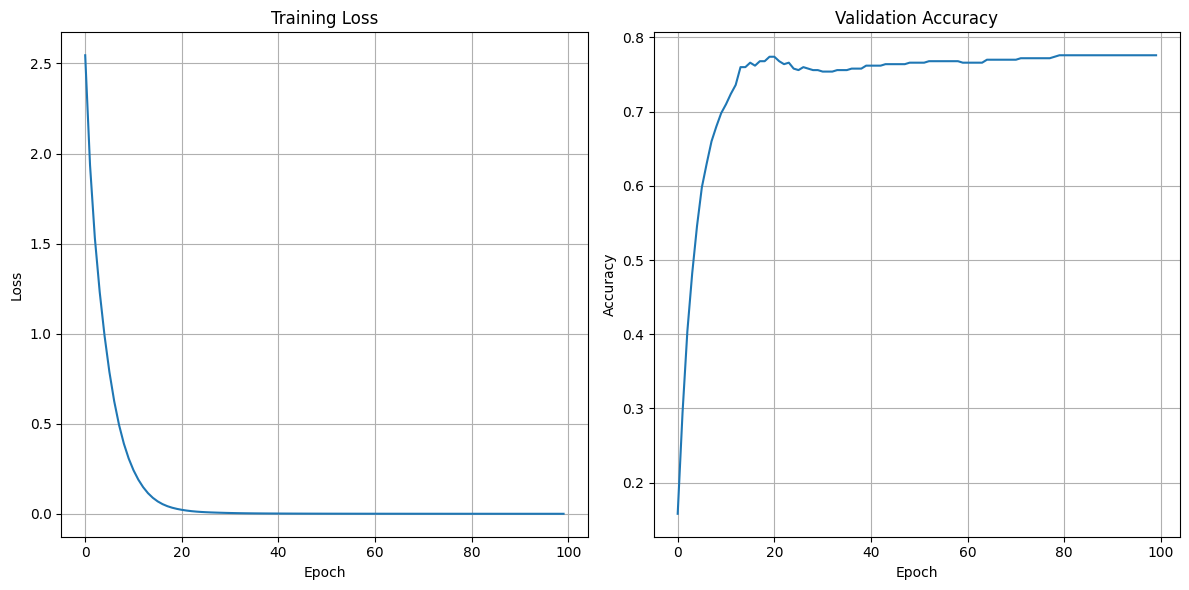

Final Training Loss: 0.0006
Final Validation Accuracy: 0.776
Test Accuracy: 0.777


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Instantiate a GCN model
num_features = data.num_features
hidden_dim = 32
num_classes = len(torch.unique(data.y))
model = GCN(num_features, hidden_dim, num_classes)

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Implement training loop
train_losses = []
val_accuracies = []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(X, hat_A_tensor)
    train_loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    train_losses.append(train_loss.item())

    # Backward pass
    train_loss.backward()
    optimizer.step()

    # Validation - accuracy
    model.eval()
    _, pred = model(X, hat_A_tensor).max(dim=1)
    correct = float(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_accuracy = correct / data.val_mask.sum().item()
    val_accuracies.append(val_accuracy)

    # Print in every 10 epochs
    if (epoch +1) % 10 == 0:
        print(f"Epoch {epoch+1}/{100}  Train loss: {train_loss.item():.4f}, Validation accuracy: {val_accuracy:.4f}")


# Plot training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)


# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# Test accuracy
model.eval()
_, pred = model(X, hat_A_tensor).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
test_accuracy = correct / data.test_mask.sum().item()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]}")
print(f"Test Accuracy: {test_accuracy}")

*Give a brief discussion on the results of your experiments.*
- Train loss: As the plot shows, the train loss is decreasing while epoch progress. The 10th epoch shows train loss 0.3076, however, the 100th epoch results 0.0006 train loss. The decreasing progress becomes dull after around 30th epoch.
- Validation accuracy: The validation accuracy is increasing while epoch progress. It illustrates that till around the 80th epoch (0.7760) the performance of model is improving, however it stuck in the same accuracy rate after on.
- Test accuracy: The final test accuracy is 0.777. It indicates that the model performed well in generalizing with the test set.

We can consider adjusting hyperparameters such as learning rate or adapting different optimizer to enhance the result.

#### Question 10 (0.5 pt)

The paper introduces GCNs as a way to solve a *semi-supervised* classification problem.

- What makes this problem semi-supervised?
- What is the proportion of labeled data used for training with respect to labeled data in the validation and test sets? What is difference in this context with other benchmark tasks in machine learning, like image classification with MNIST?
- Why do you think the GCN performs well in this semi-supervised scenario?

In [3]:
# Your answer here

# 1
print(f"Q10.1: The problem occurs in semi-supervised learning beacuse some part of nodes have labels but rest of them do not have.\nSemi-supervised learning allows to train this partial labeled data")

# 2
# Count the number of labeled nodes and sum it in each set
num_nodes = data.num_nodes
num_train = data.train_mask.sum()
num_val = data.val_mask.sum()
num_test = data.test_mask.sum()

print("\nQ10.2")
print(f'Proportion of labeled training data w.r.t. all nodes: {int(num_train) / num_nodes:.2f}')
print(f"Proportion of labeled training data w.r.t. validation set: {num_train / num_val:.2f}%")
print(f"Proportion of labeled training data w.r.t. test set: {num_train / num_test:.2f}%")

print(f"\nIn the paper, it used 20 labels per class with citatation newtwork dataset (where Cora is included).\nThe experimental set-up noted that 500 labeled examples for validation set and 1,000 labeled exampled for test set. \nThe label rate of Cora is 0.052. The proportion of training data is similar to this with repect to all data. \nIt is a bit high compared to the proportion with repect to validation set and test set (0.28% and 0.14% respectively.)")
print(f"In general, the proportion of labeled data in training data is smaller than the validation and test set when conducting the semi-supervised learning. \nAs mentioned in Q10.1, semi-supervised learning aims to utilize the limited number of labeled data to observe the dependencies of input and output.")
print(f"The difference with other benchmark tasks in machine learing like MNIST is whether data is labeled or not.\nMNIST image classification is using mostly labeled data, however, semi-supervised learning task is using partially labeled data.")

# 3
print(f"\nQ10.3: GCN performs well in the semi-supervised scenario because it propagate information from labeled nodes to unlabeled nodes employing graph structure.\nIt detects the dependencies of the nodes from checking the neighborhood of the nodes.\nIt helps the model to capture the relationships between labeled and unlabeled nodes.")
print(f"GCN allows to capture the relations between input and output using the graph structure. \nThe structural features of GCN discloses the higher-order dependencies between nodes which leads better scenario in semi-supervised setting.")
print(f'Reference: Chen, Xin, et al. "Can higher-order structural features improve the performance of graph neural networks for graph classification?." 2022 IEEE/WIC/ACM International Joint Conference on Web Intelligence and Intelligent Agent Technology (WI-IAT). IEEE, 2022.')

Q10.1: The problem occurs in semi-supervised learning beacuse some part of nodes have labels but rest of them do not have.
Semi-supervised learning allows to train this partial labeled data

Q10.2
Proportion of labeled training data w.r.t. all nodes: 0.05
Proportion of labeled training data w.r.t. validation set: 0.28%
Proportion of labeled training data w.r.t. test set: 0.14%

In the paper, it used 20 labels per class with citatation newtwork dataset (where Cora is included).
The experimental set-up noted that 500 labeled examples for validation set and 1,000 labeled exampled for test set. 
The label rate of Cora is 0.052. The proportion of training data is similar to this with repect to all data. 
It is a bit high compared to the proportion with repect to validation set and test set (0.28% and 0.14% respectively.)
In general, the proportion of labeled data in training data is smaller than the validation and test set when conducting the semi-supervised learning. 
As mentioned in Q10.1

### Loading a dataset of proteins

In the previous sections you learned how to pass the adjacency matrix of a graph with a couple of thousand of nodes, to classify each node with a particular label. A different and useful application of GCNs is graph classification.

In contrast with the previous part, where there was a single, big graph, in graph classification we have multiple graphs, and each graph can be assigned a label. In this part of the assignment you will implement a classifier for proteins.

[Proteins](https://en.wikipedia.org/wiki/Protein_(nutrient)) are parts of the buildings block of life. They consist of chains of amino acids, and can take many shapes. In the PROTEINS dataset, proteins are represented as graphs, where the nodes are amino acids, and an edge between them indicates that they are 6 [Angstroms](https://en.wikipedia.org/wiki/Angstrom) apart. All graphs have a binary label, where 1 means that the protein is not an enzyme.

We will start by loading and examining this dataset.

In [4]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='data/TU', name='PROTEINS', use_node_attr=True)

Extracting data/TU/PROTEINS/PROTEINS.zip
Processing...
Done!


#### Question 11 (0.25 pt)

Unlike in the previous part, where we selected the first element returned by the loading function, note that here we get all the elements returned by `TUDataset()`. `dataset` is an interable object, that has some similar behaviors as a Python list: you can call `len()` on it, and you can takes slices from it.

Each element in `dataset` is a `Data` object containing a graph that represents a protein. This is the same type of object that we used in the previous part to store the Cora citation network.

Knowing this, answer the following:

- How many proteins (graphs) are there in `dataset`?
- Take any protein from `dataset`. How many nodes and edges does it contain? What is its label? How many features does each node have?

In [5]:
# Your answer here

# Count the number of proteins
num_proteins = len(dataset)
print(f"The number of proteins (graphs) in dataset: {num_proteins}")

# Take any protein from dataset
selected_protein = dataset[0] # select the first protein
num_nodes = selected_protein.num_nodes
num_edges = selected_protein.num_edges
label = selected_protein.y.item()
num_node_features = selected_protein.num_node_features

print(f"The selected protein is the first protein in dataset: dataset[0]")
print(f"Number of nodes: {num_nodes}\nNumber of edges: {num_edges}")
print(f"Label of selected protein: {label}\nNumber of features in each node: {num_node_features}")

The number of proteins (graphs) in dataset: 1113
The selected protein is the first protein in dataset: dataset[0]
Number of nodes: 42
Number of edges: 162
Label of selected protein: 0
Number of features in each node: 4


#### Question 12 (0.5 pt)

To properly train and evaluate our model, we need training, validation, and test splits.

For reproducibility purposes, we generate a random tensor of indices for you. Use it to extract the three splits from `dataset`.

For training, take 80% of the indices (starting from the first element in `indices`), then the following 10% for validation, and the remaining 10% for testing. You can use the indices to index `dataset`.

Call the resulting splits `train_dataset`, `valid_dataset`, and `test_dataset`.

In [6]:
# Don't erase the following three lines
import torch
torch.random.manual_seed(0)
indices = torch.randperm(len(dataset))

# Your answer here

# Compute the size for split
train_size = int(0.8 * len(indices))
valid_size = int(0.1 * len(indices))

# Split indices based on the size
train_indices = indices[:train_size]
valid_indices = indices[train_size : train_size+valid_size]
test_indices = indices[train_size+valid_size:]

# Split the dataset
train_dataset = dataset[train_indices]
valid_dataset = dataset[valid_indices]
test_dataset = dataset[test_indices]

print(f"Total number of proteins: {len(indices)}")
print(f"Number of training proteins: {len(train_dataset)}")
print(f"Number of validation proteins: {len(valid_dataset)}")
print(f"Number of test proteins: {len(test_dataset)}")

Total number of proteins: 1113
Number of training proteins: 890
Number of validation proteins: 111
Number of test proteins: 112


### Working with a batch of graphs

When working with the Cora dataset, you used the information in `data.edge_index` to build the sparse normalized adjacency matrix $\hat{A}$ that is required by the GCN. We could do something similar here: for each graph, we build $\hat{A}$, and pass it to the GCN. However, if the number of graphs is big, this can really slow down training.

To avoid this, we will resort to a very useful trick that also allows us to reuse the same GCN you implemented previously. The trick makes it possible to do a forward pass through the GCN for multiple, disconnected graphs at the same time (instead of only one), much like when you train with mini-batches for other kinds of data.

Let's first revisit the propagation rule of the GCN, $Z = \hat{A}XW$, with an illustration (we have omitted the cells of $X$ and $W$ for clarity):

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/02-gcn-forward.png">

If we have multiple graphs, we can still use the same propagation rule, if we

- Set $\hat{A}$ to be a block diagonal matrix, where the blocks are the different adjacency matrices of the graphs
- Concatenate the feature matrices along the first dimension

This is illustrated in the following figure, for a batch of 3 graphs. Note that the elements outside of the blocks are zero.

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/02-gcn-batch-forward.png">

The resulting adjacency matrix $\hat{A}_B$ can also be built as a sparse matrix, and once we have it together with the concatenated matrix of features, the computation of the graph convolution is exactly the same as before. Note how this trick also allows us to process graphs with different sizes and structures.


#### Question 13 (0.5 pt)


Just as the citation network, the graphs in each of the datasets you created in Question 12 also have an `edge_index` attribute, which can be used to compute the normalized adjacency matrix $\hat{A}$, for each graph.

Reusing your code for Questions 3 and 5, define a function `get_a_norm()` that takes as input an element of a dataset (e.g. `train_dataset[0]`), and returns a `scipy.sparse` matrix containing $\hat{A}$.

Note that an element of a dataset has properties like `num_edges`, `num_nodes`, etc. which you can use here.

In [7]:
# Your answer here
import numpy as np
from scipy.sparse import coo_matrix, diags

def get_a_norm(element):
    # Generate adjacency matrix (A)
    edge_index = element.edge_index
    num_nodes = element.num_nodes
    row = np.array(edge_index[0])
    col = np.array(edge_index[1])
    value = np.repeat(1, element.num_edges)
    adj = coo_matrix((value, (row, col)), shape=(num_nodes, num_nodes), dtype=np.float32).toarray()

    # Generate tilde adjacency matrix (tilde_A)
    tilde_adj = adj + np.eye(num_nodes) # Add I_n to adjacency matrix

    # Generate degree matrix (tilde_D)
    tilde_d = diags(tilde_adj.sum(axis=1).flatten(), dtype=np.float32).toarray()

    # Generate normalized adjacency matrix (hat_A)
    a_norm = np.linalg.inv(np.sqrt(tilde_d)) @ tilde_adj @ np.linalg.inv(np.sqrt(tilde_d))

    return a_norm


#### Question 14 (1 pt)

To prepare the batch of graphs, we need to collect multiple adjacency matrices, feature matrices, and labels.

When using the trick described in the last figure, we see that we have to keep track of when a graph starts and when it ends, so that we can later differentiate the outputs due to $X^{(0)}$, $X^{(1)}$, etc. To achieve this, we will additionally collect a 1D array of batch indices, one for each $X^{(i)}$.

The 1D array has as many elements as rows in $X^{(i)}$, and it is filled with the value $i$ (the position of $X^{(i)}$ in the batch):

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/03-batch-indices.png">

We will later concatenate all the 1D arrays along the first dimension, just as we will do with all the $X^{(i)}$.

Define a function `prepare_graphs_batch()` that takes as input a dataset (e.g. `train_dataset`), and does the following

- Create four empty lists:
  - `adj_matrices`
  - `feature_matrices`
  - `batch_indices`
  - `labels`
- Iterate over the input dataset, getting one graph at a time. At each step, use your function from Question 13 to append the adjacency matrix to `adj_matrices`, append the matrix of input features to `feature_matrices`, create the array of batch indices (as explained above) and append it to `batch_indices`, and append the label of the graph to `labels`. **Make sure to convert the label to float**.
- Once the loop is over, use `scipy.sparse.block_diag()` to build the block diagonal matrix $\hat{A}_B$. Convert it to the COO format, and then use your answer to Question 6 to turn it into a sparse PyTorch tensor.
- Use `torch.cat()` to concatenate the tensors in `feature_matrices` along the first dimension. Do this also for `batch_indices` and `labels`.
- Return the 4 tensors computed in the previous two items.

In [8]:
# Your answer here
import torch
import numpy as np
from scipy.sparse import block_diag

def prepare_graphs_batch(dataset):
    adj_matrices = []
    feature_matrices = []
    batch_indices = []
    labels = []

    for i, data in enumerate(dataset):
        # Generate the normalized adjacency matrix and append it
        a_norm = get_a_norm(data)
        adj_matrices.append(a_norm)

        # Append the matrix of input features
        feature_matrices.append(data.x.clone().detach())

        # Create the batch indices and append it
        batch_indices.append(torch.full((data.num_nodes,), i))

        # Append the label of the graph
        labels.append(data.y.to(dtype=torch.float).clone().detach())

    # Build the block diagonal matrix hat{A}_B
    block = block_diag(adj_matrices).tocoo() #convert it to COO format
    # Use the code from question 6
    indices = np.vstack((block.row, block.col))
    indices = torch.from_numpy(indices).type(torch.int64)
    values = block.data # directly use the data from the COO sparse matrix
    values = torch.from_numpy(values).type(torch.float)
    block_tensor = torch.sparse_coo_tensor(indices=indices, values=values, size=block.shape)

    # Concatenate the tensors along the first dimension
    feature_matrices_tensor = torch.cat(feature_matrices, dim=0)
    batch_indices_tensor = torch.cat(batch_indices, dim=0)
    labels_tensor = torch.cat(labels, dim=0)

    # return the 4 tensors
    return block_tensor, feature_matrices_tensor, batch_indices_tensor, labels_tensor

Once your answer for the previous question is ready, you can run the next cell to prepare all the required information, for the train, validation, and test splits.

In [9]:
train_a_norm, train_features, train_batch_idx, train_labels = prepare_graphs_batch(train_dataset)
valid_a_norm, valid_features, valid_batch_idx, valid_labels = prepare_graphs_batch(valid_dataset)
test_a_norm, test_features, test_batch_idx, test_labels = prepare_graphs_batch(test_dataset)

### GCNs for graph classification

We now have all the ingredients to pass a batch of graphs to a GCN. However, for each graph in the batch, the output $Z^{(i)}$ contains one row for each node in the graph. If the goal is to do classification at the graph level, we have to *pool* these vectors to then compute the required logits for classification.

This operation is similar as how pooling works in a CNN. We could consider taking the mean of the vectors, the sum, or use max-pooling. The difference with respect to CNNs is that in our case, we have a batch of graphs, each potentially with a different number of nodes.

To implement this specific pooling, we can use the scatter operation in the `torch_scatter` library, which comes when installing PyG. We will use it, together with the tensor of batch indices from the previous two questions, to pool the outputs of the GCN for each graph, into a single vector:

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/04-scatter.png">

You can check more details in the [documentation](https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html).

#### Question 15 (1.0 pt)

Implement a `GraphClassifier` module using PyTorch.

- The constructor should take as arguments the number of input features, the hidden dimension, and the number of classes.
- The model should contain a instance of the `GCN` module (as you implemented it in Question 8). Use the same value for the hidden dimension and the number of output features (recall that your `GCN` module from Question 8 has two GCN layers).
- The model should also contain a `torch.nn.Linear` layer, with the hidden dimension as the input features, and the number of classes as the output.
- The forward method receives the concatenated matrix of features, the sparse block diagonal adjacency matrix, and the batch indices (the latter is used when calling `scatter`).
- Use the following architecture in the forward pass:
  - GCN $\to$ ReLU $\to$ scatter (max) $\to$ Linear.

The output of the forward should be a 1D tensor (you might need to call `squeeze` to get rid of extra dimensions) containing the logits for all graphs in the batch, for the binary classification task.

In [10]:
# Your answer here
import torch.nn as nn
import torch.nn.functional as F
from torch_scatter import scatter_max

class GraphClassifier(nn.Module):
    def __init__(self, num_input_features, hidden_dim, num_classes):
        super(GraphClassifier, self).__init__()
        self.gcn = GCN(num_input_features, hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, num_classes)
    def forward(self, feature_matrices, block_diag, batch_indices):
        Z = self.gcn(feature_matrices, block_diag)  # GCN
        Z = F.relu(Z)                               # ReLU
        Z, _ = scatter_max(Z, batch_indices, dim=0) # Scatter (max)
        output = self.linear(Z)                     # Linear
        # Get rid of extra dimensions
        return torch.squeeze(output)


#### Question 16 (1.5 pt)

Implement a training loop for the graph classifier. Use the data from Question 14 to train and evaluate the model.

We encourage you to use a GPU in this section for faster training. Note that if you change the runtime at this point, you must re-execute several of the cells above, including the ones that install PyG.

- Instantiate a classifier with 32 as the hidden dimension
- Use Adam with a learning rate of 1e-3.
- Use `torch.nn.BCEWithLogitsLoss` as the loss function.
- Train for 5,000 epochs. Once training is done, plot the loss curve and the accuracy in the validation set. Then report the accuracy in the test set.

**Note:** the logits from the output of the classifier come from a linear layer. To compute actual predictions for the calculation of the accuracy, pass the logits through `torch.sigmoid()`, and set the predicted values to 1 whenever they are greater than 0.5, and to 0 otherwise.

You should get an accuracy equal to or higher than 70% in the validation and test sets. Can you beat the [state-of-the-art](https://paperswithcode.com/sota/graph-classification-on-proteins)? Feel free to modify your architecture and experiment with it.

Discuss what you observe during training and your results.

Epoch 200/5000  Train loss: 0.6505, Validation accuracy: 0.6667
Epoch 400/5000  Train loss: 0.5722, Validation accuracy: 0.6937
Epoch 600/5000  Train loss: 0.5242, Validation accuracy: 0.7748
Epoch 800/5000  Train loss: 0.5019, Validation accuracy: 0.8108
Epoch 1000/5000  Train loss: 0.4870, Validation accuracy: 0.8288
Epoch 1200/5000  Train loss: 0.4787, Validation accuracy: 0.8198
Epoch 1400/5000  Train loss: 0.4709, Validation accuracy: 0.8018
Epoch 1600/5000  Train loss: 0.4653, Validation accuracy: 0.8018
Epoch 1800/5000  Train loss: 0.4597, Validation accuracy: 0.8198
Epoch 2000/5000  Train loss: 0.4540, Validation accuracy: 0.8378
Epoch 2200/5000  Train loss: 0.4495, Validation accuracy: 0.8288
Epoch 2400/5000  Train loss: 0.4458, Validation accuracy: 0.8288
Epoch 2600/5000  Train loss: 0.4431, Validation accuracy: 0.8288
Epoch 2800/5000  Train loss: 0.4408, Validation accuracy: 0.8288
Epoch 3000/5000  Train loss: 0.4386, Validation accuracy: 0.8198
Epoch 3200/5000  Train loss: 

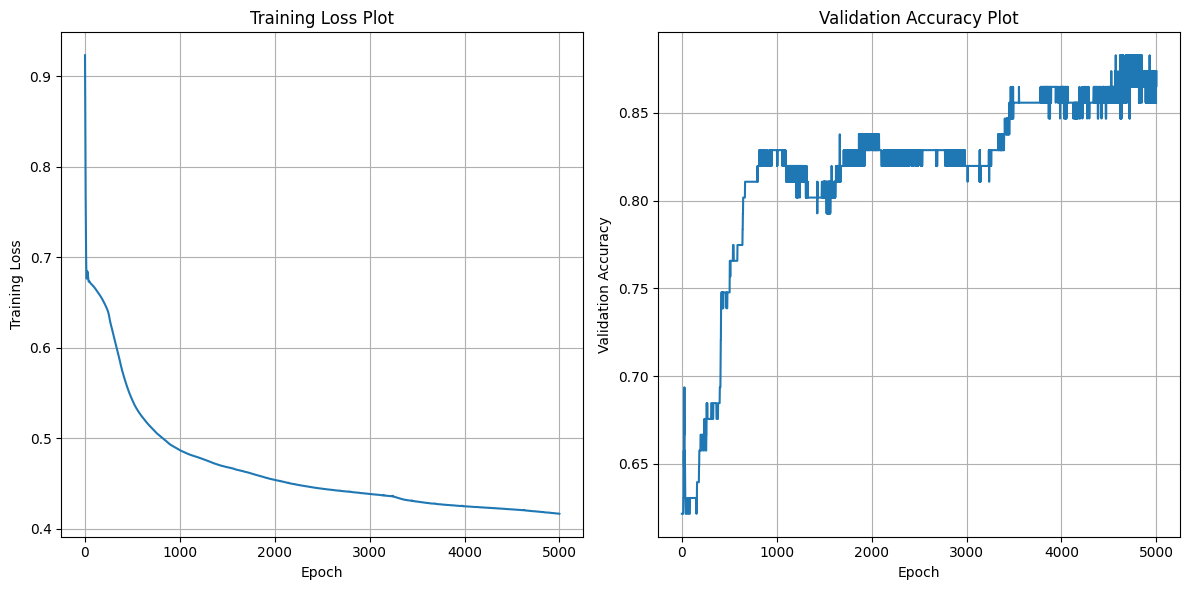

Final Training Loss: 0.4166
Final Validation Accuracy: 0.8739
Test Accuracy: 0.7054


In [22]:
# If your runtime is GPU-enabled, use .to(device) to move the model
# and all the relevant tensors to the GPU. You have to move tensors back to CPU
# when computing metrics like accuracy, using .cpu().
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

# Your answer here
import torch.optim as optim
import matplotlib.pyplot as plt

# Instantiate a classifier
classifier = GraphClassifier(num_input_features=train_features.size(1), hidden_dim=32, num_classes=1)

# Move the model and data to GPU if available
classifier.to(device)
train_a_norm = train_a_norm.to(device)
train_features = train_features.to(device)
train_batch_idx = train_batch_idx.to(device)
train_labels = train_labels.to(device)
valid_a_norm = valid_a_norm.to(device)
valid_features = valid_features.to(device)
valid_batch_idx = valid_batch_idx.to(device)
valid_labels = valid_labels.to(device)
test_a_norm = test_a_norm.to(device)
test_features = test_features.to(device)
test_batch_idx = test_batch_idx.to(device)
test_labels = test_labels.to(device)

# Set optimizer & loss function
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criteria = torch.nn.BCEWithLogitsLoss()

# Create lists to store training losses, validation accuracies
train_losses = []
val_accuracies = []

for epoch in range(5000):
    classifier.train()
    optimizer.zero_grad()

    # Forward pass
    output = classifier(train_features, train_a_norm, train_batch_idx)
    train_loss = criteria(output, train_labels)
    train_losses.append(train_loss.item()) # Append training loss

    # Backward pass
    train_loss.backward()
    optimizer.step()

    # Evaluate Validation dataset
    classifier.eval()
    with torch.no_grad():
        valid_output = classifier(valid_features, valid_a_norm, valid_batch_idx)
        valid_predicted_labels = torch.sigmoid(valid_output) > 0.5
        valid_correct = (valid_predicted_labels == valid_labels.byte()).sum().item()
        valid_accuracy = valid_correct / valid_labels.size(0)

        # Append validation accuracy
        val_accuracies.append(valid_accuracy)

    # Print in every 200 epochs
    if (epoch +1) % 200 == 0:
        print(f"Epoch {epoch+1}/{5000}  Train loss: {train_loss.item():.4f}, Validation accuracy: {valid_accuracy:.4f}")

# Plot training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Plot")
plt.grid(True)

# Plot the validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Plot")
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate test dataset
classifier.eval()
with torch.no_grad():
    test_output = classifier(test_features, test_a_norm, test_batch_idx)
    test_predicted_labels = torch.sigmoid(test_output) > 0.5
    test_correct = (test_predicted_labels == test_labels.byte()).sum().item()
    test_accuracy = test_correct / test_labels.size(0)

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

*Discuss what you observed during training and your result*

- **Training loss**: The training loss continuously decreased. At the 200th epoch, it was 0.6505 and it decreased to 0.4166 at the last epoch. It implies that model is understanding and learning the pattern of the data better as the epochs processed.
- **Validation accuracy**: The validation accuracy shows increasing trend. At the 200th epoch, it was 0.6667 and it increased to 0.8739 at the last epoch. But some plateaus epochs are captured and there are fluctuation in the graph.  It indicates that the classifier model is generalizing on the validation data, however, it implies overfitting. Early stopping or weight decay could ease this problem.
- **Test accuracy**: The test accuracy is 0.7054 at the last 5000th epoch, it retains the performance of the data with generalizing but a bit decreased compare to the validation set (0.8739). It could be becuase of the overfitting in the validation set or the different distribution of the test and validation set.


## The end

If you have made it all the way here successfully, congratulations! 🎉

You have implemented your own GCN and tested it on a node classification task, and a more challenging classification task over multiple graphs.

We hope you can use this knowledge to apply GCNs not only to the tasks described here, but other applications where data can be modeled as a graph.

If you are interested in applying graph neural networks to larger graphs, or try newer architectures, you can dive deeper into [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), a library with fast implementations for a wide range of architectures. It also comes with custom code that takes care of aspects that you dealt with manually for this assignment, like a more efficient implementation of the adjacency matrix multiplication via message-passing methods, and Data Loaders that relieve you from having to build block diagonal sparse matrices.

You can also check the [Deep Graph Library](https://docs.dgl.ai/) another powerful library for deep learning on graphs which also integrates with other backends like TensorFlow.

# Grading (10pt)

- Question 1: 0.25pt
- Question 2: 0.25pt
- Question 3: 0.5pt
- Question 4: 0.25pt
- Question 5: 0.5pt
- Question 6: 0.5pt
- Question 7: 0.5pt
- Question 8: 0.5pt
- Question 9: 1.5pt
- Question 10: 0.5pt
- Question 11: 0.25pt
- Question 12: 0.5pt
- Question 13: 0.5pt
- Question 14: 1pt
- Question 15: 1pt
- Question 16: 1.5pt